### Shopify  Data Science Challenge by Laura Manolache

In [1]:
# Imporning necessary libraries
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

__Q1:__ On Shopify, we have exactly 100 sneaker shops, and each of these shops sells only one model of shoe. We want to do some analysis of the average order value (AOV). When we look at orders data over a 30 day window, we naively calculate an AOV of $3145.13. Given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis.

__a. Think about what could be going wrong with our calculation. Think about a better way to evaluate this data.__

In [2]:
# load the dataset into a dataframe
data = pd.read_csv('data_set.csv')
data.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11


In [3]:
# Lookin at initial information about the data set
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   order_id        5000 non-null   int64 
 1   shop_id         5000 non-null   int64 
 2   user_id         5000 non-null   int64 
 3   order_amount    5000 non-null   int64 
 4   total_items     5000 non-null   int64 
 5   payment_method  5000 non-null   object
 6   created_at      5000 non-null   object
dtypes: int64(5), object(2)
memory usage: 273.6+ KB


In attempt to try to answer question Q1.a, one needs to first look at some (order_amount,order_amount since these are the features involved in the average's calculation formula) features distribution/stats to obtain further leads in our initial analysis.

In [4]:
data['order_amount'].describe()

count      5000.000000
mean       3145.128000
std       41282.539349
min          90.000000
25%         163.000000
50%         284.000000
75%         390.000000
max      704000.000000
Name: order_amount, dtype: float64

In [5]:
data['total_items'].describe()

count    5000.00000
mean        8.78720
std       116.32032
min         1.00000
25%         1.00000
50%         2.00000
75%         3.00000
max      2000.00000
Name: total_items, dtype: float64

Initial findings based on the stats obtained above:
    - the mean value for order_amount is very high (aprox. 3145.13) when compared to quantiles of the dataset;
    - the shoes are bought in bulks (maximum of items in orders is 2000) as well, which of course offsets the mean and standard deviation in the average formulae;
    - the maximum order_amount value is extremelly high (704000) when compared to 3rd quantile value (390).
    
Based on the findings above:
    - the Average Order Value (AOV) was obtained as the mean value of the order_amount for the above dataset;
    - given the maximum value in the stat above, one could infer that there might be high-value outliers in the data set which are causing the mean value to be so high.

Considering that these shops are selling the same model of affordable sneakers, there could be several potential sources for this discrepancy.

Another potential source of discrepacny - Sneaker price markups: Different shops are selling each pair of sneakers at different prices. There may be certain orders where the price of each pair is significantly higher than other orders.

Next we will investigate the prices that each pair of sneakers is being sold at by shops. To find the price of one pair of sneakers per order, divide the order_amount column by the total_items column using numpy.where. 

153.0


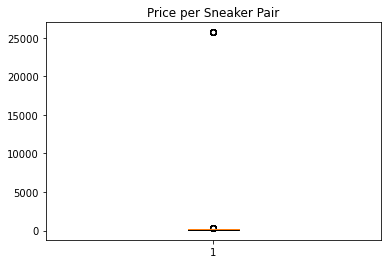

In [6]:
# Function that calculates the average price per pair each shops has in the data set
def get_price_per_pair(df):
    df['price/pair'] = np.where(df['total_items'] < 1, df['total_items'], df['order_amount']/df['total_items'])
    return df

df = get_price_per_pair(data)

# Plot the median price value per pair of sneakers in the data set
fig, ax = plt.subplots()
ax.set_title('Price per Sneaker Pair')
ax.boxplot(df['price/pair'])

price_per_pair_median = df['price/pair'].median()
print(price_per_pair_median)

The maximum average price value per pair is terible high compared to the median average value, which seems like an overpriced pair or an outlier.

In [7]:
df.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,price/pair
0,1,53,746,224,2,cash,2017-03-13 12:36:56,112.0
1,2,92,925,90,1,cash,2017-03-03 17:38:52,90.0
2,3,44,861,144,1,cash,2017-03-14 4:23:56,144.0
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37,156.0
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11,156.0


In [8]:
df[['price/pair']].describe()

,price/pair
count,5000.000000
mean,387.742800
std,2441.963725
min,90.000000
25%,133.000000
50%,153.000000
75%,169.000000
max,25725.000000


Next we will find the maximum median price value per pair and the shop associated with the value.

In [9]:
# Group by shop_id, averaging purchases per shop
p1_grouped = df.groupby(df['shop_id'])['price/pair'].mean().reset_index().sort_values(by=['price/pair'], ascending = False)
p1_grouped.head(10)

,shop_id,price/pair
77,78,25725.0
41,42,352.0
11,12,201.0
88,89,196.0
98,99,195.0
49,50,193.0
37,38,190.0
50,51,187.0
5,6,187.0
10,11,184.0


In [10]:
# Average after removing shop 78 from calculation
round(np.mean(df[df['shop_id'] != 78]['price/pair']), 2)

152.48

152 seems affordable, but the vaue has not changed much after removing outlier( shop 78).

Next looking at 'total_items' column feature.

In [11]:
df['total_items'].value_counts()

2       1832
1       1830
3        941
4        293
5         77
2000      17
6          9
8          1
Name: total_items, dtype: int64

Seems a shop has 17 orders with a bulk of 2000 pairs. Let's find this ship id.

In [12]:
df[df['total_items'] == 2000]['shop_id'].unique()

array([42], dtype=int64)

In [13]:
sneakers_p2 = df[['shop_id', 'user_id', 'order_amount', 'total_items']]

In [14]:
sneakers_p2[sneakers_p2['shop_id'] == 42].head()

,shop_id,user_id,order_amount,total_items
15,42,607,704000,2000
40,42,793,352,1
60,42,607,704000,2000
308,42,770,352,1
409,42,904,704,2


In [15]:
sneakers_p2[sneakers_p2['user_id'] == 607].head()

,shop_id,user_id,order_amount,total_items
15,42,607,704000,2000
60,42,607,704000,2000
520,42,607,704000,2000
1104,42,607,704000,2000
1362,42,607,704000,2000


Seems like the outlieir here is a unique user placing bulk orders to a unique shop. We can elimnate this outlier and recalculate the average.

In [16]:
# Average order amount without considerng shop 42 and shop 78.
round(np.mean(df[(df['shop_id'] != 42) & (df['shop_id'] != 78)])['order_amount'], 2)

300.16

In [17]:
# Average order items without considerng shop 42 and shop 78.
round(np.mean(df[(df['shop_id'] != 42) & (df['shop_id'] != 78)])['total_items'], 3)

1.996

In [18]:
# Average price scaled to 1 item
round(np.mean(df[(df['shop_id'] != 42) & (df['shop_id'] != 78)])['price/pair'], 2)

150.4

This value hasn't changed much. The conclusion is that this measure does not represent this data set correctly, it is skewed.

b. What metric would you report for this dataset?

Considering the previous analysis, we found the average wasn't the best indicator of our analysis. It seems like we weren't considering anomalies in the data set, which can lead to a skewed AOV.

In [19]:
# Looking at our order_amount once again
data['order_amount'].describe().to_frame().round(2)

,order_amount
count,5000.00
mean,3145.13
std,41282.54
min,90.00
25%,163.00
50%,284.00
75%,390.00
max,704000.00


In this case, one can observe that the dataset filtered has a clearer mean and median value.

Going back, we found that the average order amount is $300.16. This was after we removed our anomolies. But what if there was a situation where we DIDN'T want to remove any data?

Without any removal of shops, we can look at the data through percentiles.
Hence, of the percentiles we look at, 50% or MEDIAN is the metric that would best represent the data.

#### b. What metric would you report for this dataset?

Based on the findings from question 1a, the median metric seems to be less influenced by the outliers better fitted for a statistical analisys.

__c. What is its value?__

In [20]:
# Median of dataset
np.median(data['order_amount'])

284.0

In [21]:
# With shops (78 and 42 taken out)
np.median(data[(data['shop_id'] != 42) & (data['shop_id'] != 78)]['order_amount'])

284.0

### QUESTION 2a:

 There were 54 orders shipped by Speedy Express

### QUESTION 2b:

Peacock is the last name of the employee with the most orders (40)


### Question 2c

Boston Crab Meat was the product ordered the most by customers in Germany (160=count of the product)